In [1]:
import numpy as np
import random
import matplotlib
from matplotlib import pyplot as plt
import pickle

In [ ]:
N = 100
K = 20
T = 1000
Sims = 1000

CONST = 50

SEED = 19

np.random.seed(SEED)
random.seed(SEED)

def save_object_to_file(obj, file):
    with open(file, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_object_from_file(file):
    with open(file, 'rb') as handle:
        b = pickle.load(handle)
    return b

def compute_ev_regret(costs):
    rounds, K = costs.shape
    pre_val = np.zeros((1, K))
    costs_zero = np.concatenate((pre_val, costs), axis = 0)
    assert costs_zero.shape[0] == rounds + 1
    accum_costs_per = np.cumsum(costs_zero, axis = 0)[:-1,:]
    weights_per = np.exp(-accum_costs_per/np.sqrt(K))
    probs_per = weights_per/np.sum(weights_per, axis = 1, keepdims = True)
    ev_calc = np.sum(probs_per * costs, axis = -1)
    accum_costs_base = np.cumsum(costs, axis = 0)
    base_costs_idxs = np.argmin(accum_costs_base, axis = 1, keepdims = True)
    base_costs = np.take_along_axis(costs, base_costs_idxs, axis = 1).squeeze(-1)
    regret = ev_calc - base_costs
    return np.sum(regret)

def compute_ev_accum_costs(costs):
    rounds, K = costs.shape
    pre_val = np.zeros((1, K))
    costs_zero = np.concatenate((pre_val, costs), axis = 0)
    assert costs_zero.shape[0] == rounds + 1
    accum_costs_per = np.cumsum(costs_zero, axis = 0)[:-1,:]
    weights_per = np.exp(-accum_costs_per/np.sqrt(rounds))
    probs_per = weights_per/np.sum(weights_per, axis = 1, keepdims = True)
    ev_calc = np.sum(probs_per * costs, axis = -1)
    return np.sum(ev_calc)

def gen_costs_MDP_adversarial(K, rounds, trials = 2500):
    np.random.seed(SEED)
    random.seed(SEED)
    all = []
    for trial in range(trials):
        costs = gen_costs_MDP_adversarial_single(K, rounds)
        ev_costs = compute_ev_accum_costs(costs)
        ev_regret = compute_ev_regret(costs)
        all.append((ev_costs, ev_regret, costs))
    all = sorted(all)
    return all[-1][2], all[0][2]

def gen_costs_MDP_adversarial_single(arms, rounds):
    all_costs = np.zeros((rounds, arms))
    for arm in range(arms):
        arm_costs = gen_single_arm(arm, arms, rounds)
        all_costs[:,arm] = arm_costs
    return all_costs

def gen_costs_uniform_adversarial(K, rounds, trials = 2500, lo = 0.0, hi = 1):
    cost_trials = np.random.uniform(lo, hi, size = (trials, rounds + 1, K))
    cost_trials[:,0,:] = 0
    accum_costs_per = np.cumsum(cost_trials, axis = 1)[:,:-1,:]
    cost_trials = cost_trials[:,1:,:]
    weights_per = np.exp(-accum_costs_per/CONST)
    probs_per = weights_per/np.sum(weights_per, axis = 2, keepdims = True)
    print(probs_per.shape, cost_trials.shape, weights_per.shape, accum_costs_per.shape)
    ev_calc = np.sum(probs_per * cost_trials, axis = 2)
    ev_cost_trials = np.sum(ev_calc, axis = 1)
    worst_trial_idx = np.argmax(ev_cost_trials)
    best_trial_idx = np.argmin(ev_cost_trials)
    worst_costs = cost_trials[worst_trial_idx]
    best_costs = cost_trials[best_trial_idx]
    save_object_to_file(worst_costs, "adversarial_costs_worst_" + str(K) + "_" + str(rounds) + "_" + str(trials) + "_" + str(lo) + "_" + str(hi) + ".pkl")
    save_object_to_file(best_costs, "adversarial_costs_best_" + str(K) + "_" + str(rounds) + "_" + str(trials) + "_" + str(lo) + "_" + str(hi) + ".pkl")
    return worst_costs, best_costs
    

def gen_costs_sequence(K, rounds):
    seqs_p1 = [[0,0,0,1], [0.1], [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.0], [0.3], [0.25,0.25,0.5,0.25,0.75]]
    seqs_p2 = [[0,0.5,0,1], [0.2], [0,0.2,0.4,0.6,0.8], [0.4], [0.25,0,0.5,0,0.75]]
    seqs_p3 = [[0.6,0.3,0.1,0.0], [0.6,0.2], [0.2,0.2,0.2,0.8], [0.3], [0.25,0.25,0.5,0.25,0.75]]
    seqs_p4 = [[0.1,0.9,0.5,0.2,0.4], [0.2,0.4], [0.9,0.8,0.6,0.3,0.0], [0.1,0.5], [0.6,0.9,0.6,0.3,0.6]]
    seqs = seqs_p1 + seqs_p2 + seqs_p3 + seqs_p4
    
    res = []
    for arm in range(K):
        seq = seqs[arm%len(seqs)][:]
        curr_arm = []
        while len(curr_arm) < rounds:
            rem = rounds - len(curr_arm)
            curr_arm += seq[:min(rem, len(seq))]
        res.append(curr_arm)
    
    return np.array(res).T

def transition(state):
    assert type(state) == int
    assert state >= 0 and state <= 4
    weights = [[0.3, 0.3, 0.05, 0.3, 0.05], [0.3, 0.3, 0.05, 0.3, 0.05], [0.03, 0.03, 0.45, 0.04, 0.45], [0.3, 0.3, 0.05, 0.3, 0.05], [0.03, 0.03, 0.2, 0.04, 0.7]]
    next_state = random.choices([i for i in range(5)], weights = weights[state], k = 1)[0]
    return next_state

def gen_state_value(state, arm, arms):
    assert type(state) == int
    assert state >= 0 and state <= 4
    if state == 0:
        return np.random.uniform(0,0.05)
    elif state == 1:
        return np.random.uniform(0,1)
    elif state == 2:
        if arm < arms//2:
            return np.random.uniform(0.25,1)
        else:
            return np.random.uniform(0.5,1)
    elif state == 3:
        if arm < arms//4:
            return np.random.uniform(0.25,0.5)
        elif arm < arms//2:
            return np.random.uniform(0.5,0.5)
        elif arm < 3 * (arms//4):
            return np.random.uniform(0.25,0.75)
        else:
            return np.random.uniform(0.5,0.75)
    else:
        return np.random.uniform(0.2 + (0.8/arms) * arm, 1)
    

def gen_single_arm(arm, arms, rounds):
    state = random.randint(0,4)
    costs = np.zeros(rounds)
    for cr in range(rounds):
        state = transition(state)
        costs[cr] = gen_state_value(state, arm, arms)
    return costs

def gen_costs_MDP(arms, rounds):
    np.random.seed(SEED)
    random.seed(SEED)
    all_costs = np.zeros((rounds, arms))
    for arm in range(arms):
        arm_costs = gen_single_arm(arm, arms, rounds)
        all_costs[:,arm] = arm_costs
    return all_costs

def gen_costs_uniform(arms, rounds):
    np.random.seed(SEED)
    random.seed(SEED)
    base = np.random.uniform(0,1, size = (rounds, arms))
    return base

def gen_costs_half_max(arms, rounds):
    base = np.random.uniform(0,1, size = (rounds, arms))
    upper = np.random.uniform(0,1, size = (rounds, arms//2))
    upper = np.concatenate((upper, np.zeros((rounds, arms - arms//2))), axis = 1)
    return np.maximum(base, upper)

def gen_costs_per_max(arms, rounds):
    all_costs = np.zeros((rounds, arms))
    for arm in range(arms):
        x = np.random.uniform(0,1,size = (rounds,))
        for i in range(arm):
            y = np.random.uniforM(0,1,size = (rounds,))
            x = np.maximum(x, y)
        all_costs[:,arm] = x
    return all_costs

def gen_all_costs(arms, rounds, func):
    return func(arms, rounds)

def gen_costs(arms):
    return np.random.uniform(0,1, size = (arms,))

def actions_expw(agents, s, T):
    weights = np.exp(-s/np.sqrt(T))
    probs   = weights/np.sum(weights)
    arms    = [i for i,x in enumerate(probs)]
    actions = random.choices(arms, weights = weights, k = agents)
    return [int(i) for i in actions]

def actions_coop(agents, s, T):
    weights = np.exp(-s/np.sqrt(T))
    probs   = weights/np.sum(weights)
    arms    = [i for i,x in enumerate(probs)]
    full_probs = agents * probs
    actions = np.zeros(agents) - 1
    det_count = 0
    for agent in range(agents):
        for arm, prob in enumerate(full_probs):
            if prob >= 1:
                det_count += 1
                actions[agent] = int(arm)
                full_probs[arm] -= 1
                break
        if actions[agent] == -1:
            rem_agents = agents - agent
            select_dist = full_probs/rem_agents
            actions[agent] = int(random.choices(arms, weights = select_dist, k = 1)[0])
            full_probs -= select_dist
            
    return [int(i) for i in actions]

def get_actions(agents, s, T):
    return (actions_expw(agents, s, T), actions_coop(agents, s, T))

def sim_round(agents, arms, s, costs = None, T = 1000): 
    if costs is None:
        costs = gen_costs(arms)
    a_expw, a_coop = get_actions(agents, s, T)
    expw_cost, coop_cost = np.sum(costs[a_expw]), np.sum(costs[a_coop])
    min_cost = costs[np.argmin(s + costs)]
    base_cost = min_cost * agents
    expw_regret, coop_regret = expw_cost - base_cost, coop_cost - base_cost
    return expw_regret, coop_regret, s + costs, expw_cost, coop_cost, base_cost

def sim(agents, arms, rounds, all_costs = None):
    s = np.zeros(arms)
    regret_expw = 0
    regret_coop = 0
    cost_expw   = 0
    cost_coop   = 0
    cost_base   = 0
    reg_expw_hist = [regret_expw]
    reg_coop_hist = [regret_coop]
    cost_expw_hist = [0]
    cost_coop_hist = [0]
    cost_base_hist = []
    for curr_round in range(rounds):
        costs = None
        if not(all_costs is None):
            costs = all_costs[curr_round]
        round_regret_expw, round_regret_coop, s, round_cost_expw, round_cost_coop, round_cost_base = sim_round(agents, arms, s, costs, rounds)
        regret_expw += round_regret_expw
        regret_coop += round_regret_coop
        cost_expw   += round_cost_expw
        cost_coop   += round_cost_coop
        cost_base   += round_cost_base
        reg_expw_hist.append(regret_expw)
        reg_coop_hist.append(regret_coop)
        cost_expw_hist.append(cost_expw)
        cost_coop_hist.append(cost_coop)
        cost_base_hist.append(cost_base)
    return reg_expw_hist, reg_coop_hist, cost_expw_hist, cost_coop_hist, cost_base_hist

def conduct_experiment(agents, arms, rounds, sims, func, all_costs = None, verbose_iter = -1):
    if all_costs is None:
        all_costs = gen_all_costs(arms, rounds, func)
    all_expw_regrets, all_coop_regrets = [], []
    all_expw_costs, all_coop_costs = [], []
    all_base_costs = []
    for curr_sim in range(sims):
        #if (curr_sim + 1)%10 == 0:
            #print(curr_sim + 1)
        if verbose_iter > -1:
            if curr_sim%verbose_iter == 0:
                print("Sim:", curr_sim)
        curr_expw_regrets, curr_coop_regrets, curr_expw_costs, curr_coop_costs, curr_base_costs = sim(agents, arms, rounds, all_costs)
        all_expw_regrets.append(curr_expw_regrets)
        all_coop_regrets.append(curr_coop_regrets)
        all_expw_costs.append(curr_expw_costs)
        all_coop_costs.append(curr_coop_costs)
        all_base_costs.append(curr_base_costs)
    return all_expw_regrets, all_coop_regrets, all_expw_costs, all_coop_costs, all_base_costs

def disp_results(all_expw_regrets, all_coop_regrets):
    avg_expw = np.mean(all_expw_regrets, axis = 0)
    avg_coop = np.mean(all_coop_regrets, axis = 0)
    std_expw = np.std(all_expw_regrets, axis = 0)
    std_coop = np.std(all_coop_regrets, axis = 0)

    x_axis = np.arange(len(avg_expw))

    plt.clf()
    plt.fill_between(x_axis, avg_expw - std_expw, avg_expw + std_expw, color = "C0", alpha = 0.5)
    plt.fill_between(x_axis, avg_coop - std_coop, avg_coop + std_coop, color = "C1", alpha = 0.5)
    plt.plot(x_axis, avg_expw, label = "exponential weights")
    plt.plot(x_axis, avg_coop, label = "cooperative deterministic exp. weights")
    plt.title("Average Total Accumulated Regret +/- 1 STD over Rounds")
    plt.xlabel("Rounds")
    plt.ylabel("Average Total Accumulated Regret")
    plt.legend(loc = "lower right")
    plt.show()
    plt.clf()

    plt.clf()
    plt.plot(x_axis, avg_expw, label = "exponential weights")
    plt.plot(x_axis, avg_coop, label = "cooperative deterministic exp. weights")
    plt.title("Average Total Accumulated Regret over Rounds")
    plt.xlabel("Rounds")
    plt.ylabel("Average Total Accumulated Regret")
    plt.legend(loc = "lower right")
    plt.show()
    plt.clf()

    plt.clf()
    plt.plot(x_axis, std_expw, label = "exponential weights")
    plt.plot(x_axis, std_coop, label = "cooperative deterministic exp. weights")
    plt.title("Standard deviation of regret over experiments over Rounds")
    plt.xlabel("Rounds")
    plt.ylabel("Standard deviation of regret over experiments")
    plt.legend(loc = "lower right")
    plt.show()
    plt.clf()

    plt.clf()
    plt.plot(x_axis, np.mean(all_expw_regrets - all_coop_regrets, axis = 0))
    plt.title("Avg. Regret Diff. between Exp. Weights and Coop. Det.")
    plt.xlabel("Rounds")
    plt.ylabel("Average Regret Difference")
    plt.show()
    plt.clf()
    
    print("Exponential Weights Average Regret: " + str(avg_expw[-1]))
    print("Cooperative Deterministic Exponential Weights Average Regret: " + str(avg_coop[-1]))
    print("Difference in Average Regret between Exponential Weights and Cooperative Deterministic Exponential Weights: " + str(avg_coop[-1] - avg_expw[-1]))
    print("Percent Difference in Average Regret (Exp. Weights is denominator): " + str(100 * (avg_coop[-1] - avg_expw[-1])/(avg_expw[-1])) + "%")
    
    print("Exponential Weights Regret Standard Deviation: " + str(std_expw[-1]))
    print("Cooperative Deterministic Exponential Weights Regret Standard Deviation: " + str(std_coop[-1]))
    print("Difference in Standard Deviation between Exponential Weights and Cooperative Deterministic Exponential Weights: " + str(std_expw[-1] - std_coop[-1]))
    print("Percent Drop Coop. Det is in Standard Deviation of Regret: " + str(100 * (std_expw[-1] - std_coop[-1])/(std_expw[-1])) + "%")
    
def get_results(all_expw_regrest, all_coop_regrets):
    avg_expw = np.mean(all_expw_regrets, axis = 0)
    avg_coop = np.mean(all_coop_regrets, axis = 0)
    std_expw = np.std(all_expw_regrets, axis = 0)
    std_coop = np.std(all_coop_regrets, axis = 0)

    x_axis = np.arange(len(avg_expw))

    perc_drop = 100 * (std_expw[-1] - std_coop[-1])/(std_expw[-1])
    return std_expw[-1], std_coop[-1], perc_drop    

Ks = [20]
Ns = [100, 50, 20, 10]
Ts = [50, 100, 1000]
all_Sims = [1000]

each_expw_regrets, each_coop_regrets = [], []
each_expw_costs, each_coop_costs = [], []
each_base_costs = []
all_data = []

verbose_iter = 100


mdp_single_small, (mdp_worst_small, mdp_best_small) = gen_costs_MDP(20, 50), gen_costs_MDP_adversarial(20, 50)
uniform_single_small, (uniform_worst_small, uniform_best_small) = gen_costs_uniform(20, 50), gen_costs_uniform_adversarial(20, 50, trials = 100000)
mdp_single_full, (mdp_worst_full, mdp_best_full) = gen_costs_MDP(20, 1000), gen_costs_MDP_adversarial(20, 1000, trials = 50)
uniform_single_full, (uniform_worst_full, uniform_best_full) = gen_costs_uniform(20, 1000), gen_costs_uniform_adversarial(20, 1000, trials = 10000)
mdp_single_medium, (mdp_worst_medium, mdp_best_medium) = gen_costs_MDP(20, 100), gen_costs_MDP_adversarial(20, 100, trials = 1000)
uniform_single_medium, (uniform_worst_medium, uniform_best_medium) = gen_costs_uniform(20, 100), gen_costs_uniform_adversarial(20, 100, trials = 10000)

# print(compute_ev_accum_costs(mdp_worst_medium), compute_ev_regret(mdp_worst_medium))
# print(compute_ev_accum_costs(mdp_best_medium), compute_ev_regret(mdp_best_medium))
# print(compute_ev_regret(mdp_worst_medium) - compute_ev_regret(mdp_best_medium))

# print(compute_ev_accum_costs(mdp_worst_small), compute_ev_regret(mdp_worst_small))
# print(compute_ev_accum_costs(mdp_best_small), compute_ev_regret(mdp_best_small))
# print(compute_ev_regret(mdp_worst_small) - compute_ev_regret(mdp_best_small))
# print()
# print(compute_ev_accum_costs(uniform_worst_small), compute_ev_regret(uniform_worst_small))
# print(compute_ev_accum_costs(uniform_best_small), compute_ev_regret(uniform_best_small))
# print(compute_ev_regret(uniform_worst_small) - compute_ev_regret(uniform_best_small))

costs_dict = {
    "Uniform_Best" : [uniform_best_small, uniform_best_medium, uniform_best_full],
    "Uniform_Worst" : [uniform_worst_small, uniform_worst_medium, uniform_worst_full],
    "Uniform_Single" : [uniform_single_small, uniform_single_medium, uniform_single_full],
    "MDP_Best" : [mdp_best_small, mdp_best_medium, mdp_best_full],
    "MDP_Worst" : [mdp_worst_small, mdp_worst_medium, mdp_worst_full],
    "MDP_Single" : [mdp_single_small, mdp_single_medium, mdp_single_full]
}

# norm, adv = gen_costs_MDP(20, 1000), gen_costs_MDP_adversarial(20, 1000)
# print(compute_ev_accum_costs(norm), compute_ev_regret(norm))
# print(compute_ev_accum_costs(adv), compute_ev_regret(adv))

# norm, adv = gen_costs_uniform(20, 1000), gen_costs_uniform_adversarial(20, 1000)
# print(compute_ev_accum_costs(norm), compute_ev_regret(norm))
# print(compute_ev_accum_costs(adv), compute_ev_regret(adv))


def run_func(TAG, Ns, Ks, Ts, all_Sims, track_sub_experiments = True, verbose_iter = 100, display = False):
    entire_data = []
    for K in Ks:
        for tidx, T in enumerate(Ts):
            ALL_COSTS = costs_dict[TAG][tidx]
            print(compute_ev_accum_costs(ALL_COSTS), compute_ev_regret(ALL_COSTS))
            for N in Ns:
                for Sims in all_Sims:
                    print("Experiment " + str(TAG) + ": ", N, K, T, Sims)
                    all_expw_regrets, all_coop_regrets, all_expw_costs, all_coop_costs, all_base_costs = conduct_experiment(N, K, T, Sims, None, ALL_COSTS, verbose_iter)
    
                    all_expw_regrets = np.array(all_expw_regrets)
                    all_coop_regrets = np.array(all_coop_regrets)
                    all_expw_costs = np.array(all_expw_costs)
                    all_coop_costs = np.array(all_coop_costs)
                    all_base_costs = np.array(all_base_costs)
                    assert len(all_expw_regrets.shape) == 2 and len(all_coop_regrets.shape) == 2
                    assert all_expw_regrets.shape == all_coop_regrets.shape
    
                    each_expw_regrets.append(all_expw_regrets)
                    each_coop_regrets.append(all_coop_regrets)
                    each_expw_costs.append(all_expw_costs)
                    each_coop_costs.append(all_coop_costs)
                    each_base_costs.append(all_base_costs)
    
                    curr_data = [all_expw_regrets, all_coop_regrets, all_expw_costs, all_coop_costs, all_base_costs]
                    entire_data.append(curr_data)
                    if track_sub_experiments:
                        file = "Partial_" + TAG + "_" + str(N) + "_" + str(K) + "_" + str(T) + "_" + str(Sims)
                        save_object_to_file(curr_data, file + ".pkl")
                    if display:
                        disp_results(all_expw_regrets, all_coop_regrets)
                        disp_results(all_expw_costs, all_coop_costs)
                        disp_results(all_base_costs, all_base_costs)

    file = "Whole_" + TAG + "_" + str(len(Ns)) + "Ns" + "_" + str(len(Ks)) + "Ks" + "_" + str(len(Ts)) + "Ts" + "_" + str(len(all_Sims)) + "nSims"
    save_object_to_file(entire_data, file + ".pkl")


for TAG in sorted(costs_dict.keys()):
    run_func(TAG, Ns, Ks, Ts, all_Sims, True, 100, False)
    run_func(TAG, [i for i in range(1,101)], Ks, Ts, [100], False, 100, False)
    


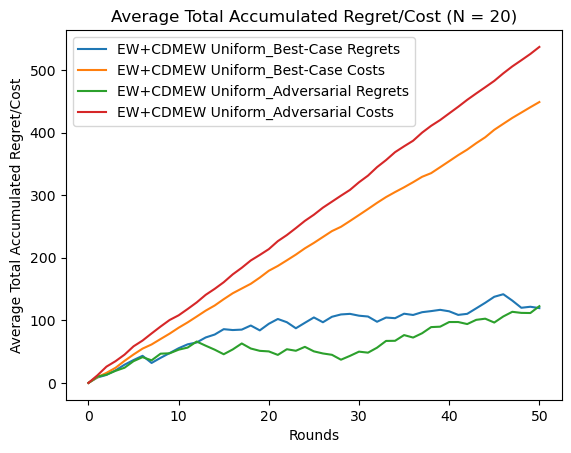

<Figure size 640x480 with 0 Axes>

In [47]:
# PLOT 1
# Plot with 20 agents -> U(0,1) best-case against U(0,1) Adversarial to display adaptation ->

U_0_1_best_data = load_object_from_file("Partial_Uniform_Best_20_20_50_1000.pkl")
U_0_1_adverse_data = load_object_from_file("Partial_Uniform_Worst_20_20_50_1000.pkl")

best_expw_regrets = U_0_1_best_data[0]
best_expw_costs   = U_0_1_best_data[2]
adverse_expw_regrets = U_0_1_adverse_data[0]
adverse_expw_costs   = U_0_1_adverse_data[2]

avg_best_expw_regrets = np.mean(best_expw_regrets, axis = 0)
avg_best_expw_costs   = np.mean(best_expw_costs, axis = 0)
avg_adverse_expw_regrets = np.mean(adverse_expw_regrets, axis = 0)
avg_adverse_expw_costs   = np.mean(adverse_expw_costs, axis = 0)

x_axis = np.arange(len(avg_adverse_expw_costs))

plt.clf()

plt.plot(x_axis, avg_best_expw_regrets, label = "EW+CDMEW Uniform_Best-Case Regrets")
plt.plot(x_axis, avg_best_expw_costs, label = "EW+CDMEW Uniform_Best-Case Costs")
plt.plot(x_axis, avg_adverse_expw_regrets, label = "EW+CDMEW Uniform_Adversarial Regrets")
plt.plot(x_axis, avg_adverse_expw_costs, label = "EW+CDMEW Uniform_Adversarial Costs")

plt.title("Average Total Accumulated Regret/Cost (N = 20)")
plt.xlabel("Rounds")
plt.ylabel("Average Total Accumulated Regret/Cost")
plt.legend(loc = "upper left")
plt.show()
plt.clf()

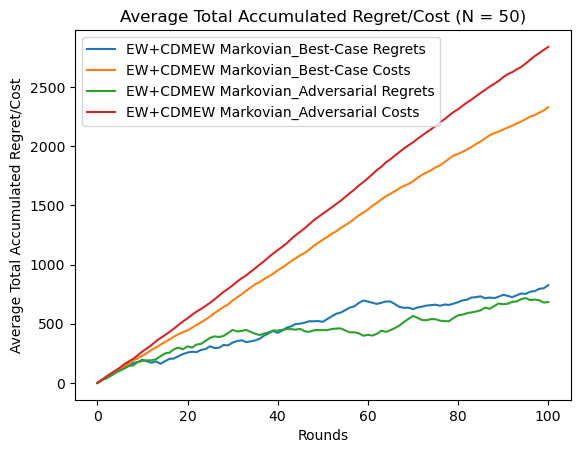

<Figure size 640x480 with 0 Axes>

In [68]:
# PLOT 2
# Plot with 50 agents -> MDP adversarial against MDP best-case to display that
# our algorithm can adapt

mdp_best_data = load_object_from_file("Partial_MDP_Best_50_20_100_1000.pkl")
mdp_adverse_data = load_object_from_file("Partial_MDP_Worst_50_20_100_1000.pkl")

best_expw_regrets = mdp_best_data[0]
best_expw_costs   = mdp_best_data[2]
adverse_expw_regrets = mdp_adverse_data[0]
adverse_expw_costs   = mdp_adverse_data[2]

avg_best_expw_regrets = np.mean(best_expw_regrets, axis = 0)
avg_best_expw_costs   = np.mean(best_expw_costs, axis = 0)
avg_adverse_expw_regrets = np.mean(adverse_expw_regrets, axis = 0)
avg_adverse_expw_costs   = np.mean(adverse_expw_costs, axis = 0)

x_axis = np.arange(len(avg_adverse_expw_costs))

plt.clf()

plt.plot(x_axis, avg_best_expw_regrets, label = "EW+CDMEW Markovian_Best-Case Regrets")
plt.plot(x_axis, avg_best_expw_costs, label = "EW+CDMEW Markovian_Best-Case Costs")
plt.plot(x_axis, avg_adverse_expw_regrets, label = "EW+CDMEW Markovian_Adversarial Regrets")
plt.plot(x_axis, avg_adverse_expw_costs, label = "EW+CDMEW Markovian_Adversarial Costs")

plt.title("Average Total Accumulated Regret/Cost (N = 50)")
plt.xlabel("Rounds")
plt.ylabel("Average Total Accumulated Regret/Cost")
plt.legend(loc = "upper left")
plt.show()
plt.clf()

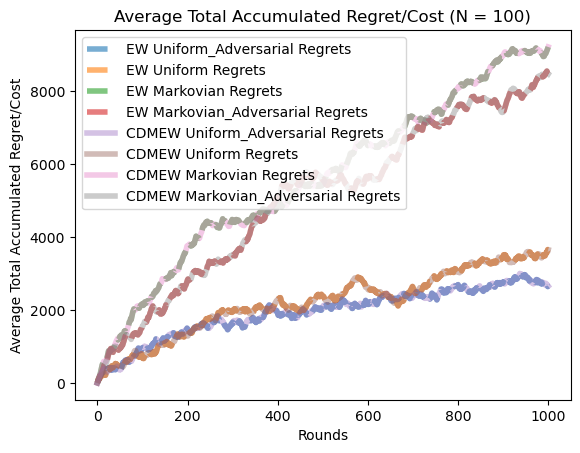

<Figure size 640x480 with 0 Axes>

In [55]:
# PLOT 3
# Plot with 100 agents -> U(0,1), MDP Adversarial with EXPW and CDMEW to display that the
# new algorithm we propose matches identically with EXPW in cost accumulation and regret
# Showing this in adversarial setting since our problem formulation is set in this setting.

U_0_1_single_data = load_object_from_file("Partial_Uniform_Single_100_20_1000_1000.pkl")
U_0_1_adverse_data = load_object_from_file("Partial_Uniform_Worst_100_20_1000_1000.pkl")
MDP_single_data = load_object_from_file("Partial_MDP_Single_100_20_1000_1000.pkl")
MDP_adverse_data = load_object_from_file("Partial_MDP_Worst_100_20_1000_1000.pkl")

adverse_expw_regrets = U_0_1_adverse_data[0]
adverse_coop_regrets = U_0_1_adverse_data[1]
single_expw_regrets = U_0_1_single_data[0]
single_coop_regrets = U_0_1_single_data[1]
mdp_expw_regrets = MDP_single_data[0]
mdp_coop_regrets = MDP_single_data[1]
mdp_adverse_expw_regrets = MDP_adverse_data[0]
mdp_adverse_coop_regrets = MDP_adverse_data[1]

avg_adverse_expw_regrets = np.mean(adverse_expw_regrets, axis = 0)
avg_adverse_coop_regrets = np.mean(adverse_coop_regrets, axis = 0)
avg_single_expw_regrets = np.mean(single_expw_regrets, axis = 0)
avg_single_coop_regrets = np.mean(single_coop_regrets, axis = 0)
avg_mdp_expw_regrets = np.mean(mdp_expw_regrets, axis = 0)
avg_mdp_coop_regrets = np.mean(mdp_coop_regrets, axis = 0)
avg_mdp_adverse_expw_regrets = np.mean(mdp_adverse_expw_regrets, axis = 0)
avg_mdp_adverse_coop_regrets = np.mean(mdp_adverse_coop_regrets, axis = 0)

x_axis = np.arange(len(avg_adverse_expw_regrets))

plt.clf()

LW = 4
plt.plot(x_axis, avg_adverse_expw_regrets, label = "EW Uniform_Adversarial Regrets", alpha = 0.6, linestyle = 'dashed', linewidth = LW)
plt.plot(x_axis, avg_single_expw_regrets, label = "EW Uniform Regrets", alpha = 0.6, linestyle = 'dashed', linewidth = LW)
plt.plot(x_axis, avg_mdp_expw_regrets, label = "EW Markovian Regrets", alpha = 0.6, linestyle = 'dashed', linewidth = LW)
plt.plot(x_axis, avg_mdp_adverse_expw_regrets, label = "EW Markovian_Adversarial Regrets", alpha = 0.6, linestyle = 'dashed', linewidth = LW)
plt.plot(x_axis, avg_adverse_coop_regrets, label = "CDMEW Uniform_Adversarial Regrets", alpha = 0.4, linewidth = LW)
plt.plot(x_axis, avg_single_coop_regrets, label = "CDMEW Uniform Regrets", alpha = 0.4, linewidth = LW)
plt.plot(x_axis, avg_mdp_coop_regrets, label = "CDMEW Markovian Regrets", alpha = 0.4, linewidth = LW)
plt.plot(x_axis, avg_mdp_adverse_coop_regrets, label = "CDMEW Markovian_Adversarial Regrets", alpha = 0.4, linewidth = LW)

plt.title("Average Total Accumulated Regret/Cost (N = 100)")
plt.xlabel("Rounds")
plt.ylabel("Average Total Accumulated Regret/Cost")
plt.legend(loc = "upper left")
plt.show()
plt.clf()

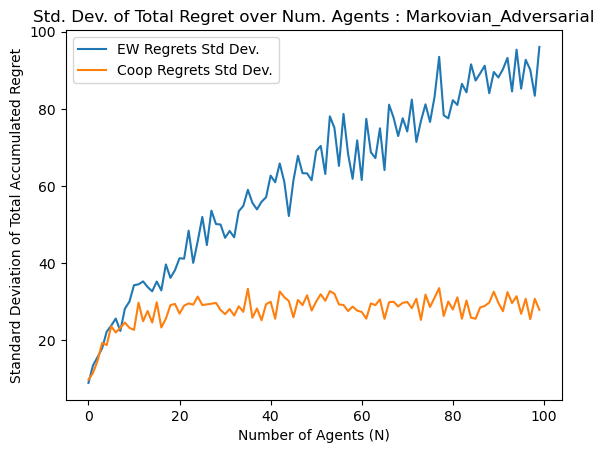

<Figure size 640x480 with 0 Axes>

In [13]:
# PLOT 4
# SD Plot with agents N in range[1,100] -> MDP scenario
# Computes the SD of the regret for each N in this range

MDP_data = load_object_from_file("Whole_MDP_Worst_100Ns_1Ks_3Ts_1nSims.pkl")[-100:]

expw_regrets_std = [np.std(i[0], axis = 0)[-1] for i in MDP_data]
coop_regrets_std = [np.std(i[1], axis = 0)[-1] for i in MDP_data]

x_axis = np.arange(len(expw_regrets_std))

plt.clf()

plt.plot(x_axis, expw_regrets_std, label = "EW Regrets Std Dev.")
plt.plot(x_axis, coop_regrets_std, label = "Coop Regrets Std Dev.")

plt.title("Std. Dev. of Total Regret over Num. Agents : Markovian_Adversarial")
plt.xlabel("Number of Agents (N)")
plt.ylabel("Standard Deviation of Total Accumulated Regret")
plt.legend(loc = "upper left")

plt.show()

plt.clf()

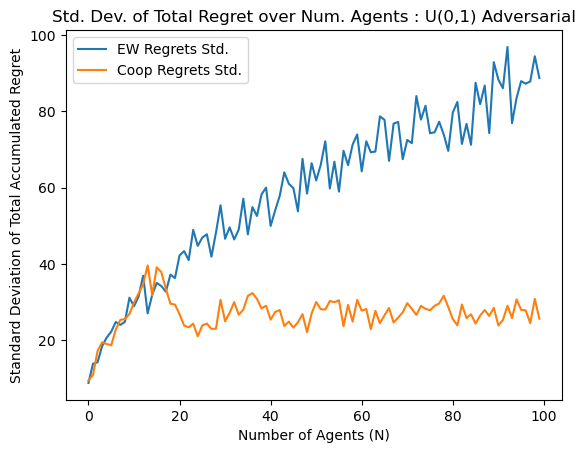

<Figure size 640x480 with 0 Axes>

In [12]:
# PLOT 5
# SD Plot with agents N in range[1,100] -> U(0,1) Adversarial scenario
# Computes the SD of the regret for each N in this range

U_0_1_Adversarial_data = load_object_from_file("Whole_Uniform_Worst_100Ns_1Ks_3Ts_1nSims.pkl")[-100:]

expw_regrets_std = [np.std(i[0], axis = 0)[-1] for i in U_0_1_Adversarial_data]
coop_regrets_std = [np.std(i[1], axis = 0)[-1] for i in U_0_1_Adversarial_data]

x_axis = np.arange(len(expw_regrets_std))

plt.clf()

plt.plot(x_axis, expw_regrets_std, label = "EW Regrets Std.")
plt.plot(x_axis, coop_regrets_std, label = "Coop Regrets Std.")

plt.title("Std. Dev. of Total Regret over Num. Agents : U(0,1) Adversarial")
plt.xlabel("Number of Agents (N)")
plt.ylabel("Standard Deviation of Total Accumulated Regret")
plt.legend(loc = "upper left")

plt.show()

plt.clf()

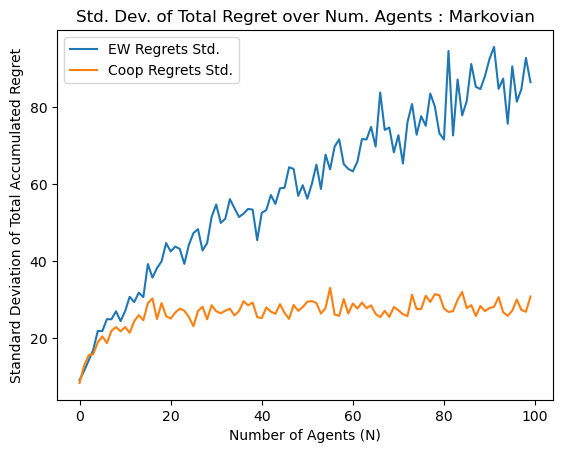

<Figure size 640x480 with 0 Axes>

In [15]:
# PLOT 6
# SD Plot with agents N in range[1,100] -> MDP Single Random scenario
# Computes the SD of the regret for each N in this range

MDP_Rand_data = load_object_from_file("Whole_MDP_Single_100Ns_1Ks_3Ts_1nSims.pkl")[-100:]

expw_regrets_std = [np.std(i[0], axis = 0)[-1] for i in MDP_Rand_data]
coop_regrets_std = [np.std(i[1], axis = 0)[-1] for i in MDP_Rand_data]

x_axis = np.arange(len(expw_regrets_std))

plt.clf()

plt.plot(x_axis, expw_regrets_std, label = "EW Regrets Std.")
plt.plot(x_axis, coop_regrets_std, label = "Coop Regrets Std.")

plt.title("Std. Dev. of Total Regret over Num. Agents : Markovian")
plt.xlabel("Number of Agents (N)")
plt.ylabel("Standard Deviation of Total Accumulated Regret")
plt.legend(loc = "upper left")

plt.show()

plt.clf()